In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's load the different bird species from the `class_names.npy` file and then the attributes from `attributes.npy` which has for every class 312 features that are explained by the file `attributes.txt`.

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [5]:
glob_path = "drive/MyDrive/"

In [6]:
bird_classes = np.load(glob_path + "data/class_names.npy", allow_pickle=True).item()

In [7]:
attributes = np.load(glob_path + 'data/attributes.npy')
attributes.shape

(200, 312)

In [8]:
with open(glob_path + "data/attributes.txt", "r") as f:
    attribute_names = [line.strip() for line in f.readlines()]

attribute_names[:5]

['1 has_bill_shape::curved_(up_or_down)',
 '2 has_bill_shape::dagger',
 '3 has_bill_shape::hooked',
 '4 has_bill_shape::needle',
 '5 has_bill_shape::hooked_seabird']

Unify the attributes files to map for every bird species they're features

In [9]:
class_attributes = {}

for class_id in range(attributes.shape[0]):
    class_attributes[class_id + 1] = {
        attribute_names[i]: attributes[class_id, i] for i in range(len(attribute_names))
    }

Create a data frame `birds_df` with the class_id and the 312 attrbiutes of each bird class. Then merge it with the class name of each bird.

In [10]:
birds_df = pd.DataFrame.from_dict(class_attributes, orient="index")
birds_df.index.name = "class_id"
birds_df.reset_index(inplace=True)
birds_df.head()

,class_id,1 has_bill_shape::curved_(up_or_down),2 has_bill_shape::dagger,3 has_bill_shape::hooked,4 has_bill_shape::needle,5 has_bill_shape::hooked_seabird,6 has_bill_shape::spatulate,7 has_bill_shape::all-purpose,8 has_bill_shape::cone,9 has_bill_shape::specialized,...,303 has_crown_color::pink,304 has_crown_color::orange,305 has_crown_color::black,306 has_crown_color::white,307 has_crown_color::red,308 has_crown_color::buff,309 has_wing_pattern::solid,310 has_wing_pattern::spotted,311 has_wing_pattern::striped,312 has_wing_pattern::multi-colored
0,1,0.010638,0.010638,0.007092,0.003546,0.138299,0.065603,0.000000,0.005319,0.000000,...,0.000000,0.005439,0.005439,0.228446,0.000000,0.000000,0.186020,0.009186,0.025262,0.020669
1,2,0.000000,0.011332,0.009444,0.000000,0.202095,0.041552,0.015110,0.005666,0.000000,...,0.006291,0.000000,0.111144,0.008388,0.000000,0.046135,0.202572,0.002665,0.021323,0.058639
2,3,0.000000,0.000000,0.007425,0.000000,0.002475,0.000000,0.000000,0.074247,0.146020,...,0.000000,0.000000,0.190411,0.012555,0.000000,0.010462,0.203609,0.000000,0.008853,0.017705
3,4,0.000000,0.000000,0.003861,0.000000,0.003861,0.013514,0.005792,0.073360,0.138998,...,0.004885,0.000000,0.190531,0.000000,0.000000,0.000000,0.152750,0.006840,0.036478,0.043317
4,5,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.102458,0.070177,0.000000,...,0.000000,0.000000,0.204036,0.002458,0.002458,0.000000,0.031640,0.002751,0.015132,0.158200


In [11]:
classes = pd.DataFrame.from_dict(bird_classes, orient="index").reset_index()
classes.columns = ["class", "id"]
classes.head()

,class,id
0,001.Black_footed_Albatross,1
1,002.Laysan_Albatross,2
2,003.Sooty_Albatross,3
3,004.Groove_billed_Ani,4
4,005.Crested_Auklet,5


In [12]:
birds_df = birds_df.merge(classes, left_on="class_id", right_on="id")
birds_df = birds_df.drop(columns=["id"])

# Reorder columns to have class_id and class first
cols = ["class_id", "class"] + [c for c in birds_df.columns if c not in ["class_id", "class"]]
birds_df = birds_df[cols]
birds_df.head()

,class_id,class,1 has_bill_shape::curved_(up_or_down),2 has_bill_shape::dagger,3 has_bill_shape::hooked,4 has_bill_shape::needle,5 has_bill_shape::hooked_seabird,6 has_bill_shape::spatulate,7 has_bill_shape::all-purpose,8 has_bill_shape::cone,...,303 has_crown_color::pink,304 has_crown_color::orange,305 has_crown_color::black,306 has_crown_color::white,307 has_crown_color::red,308 has_crown_color::buff,309 has_wing_pattern::solid,310 has_wing_pattern::spotted,311 has_wing_pattern::striped,312 has_wing_pattern::multi-colored
0,1,001.Black_footed_Albatross,0.010638,0.010638,0.007092,0.003546,0.138299,0.065603,0.000000,0.005319,...,0.000000,0.005439,0.005439,0.228446,0.000000,0.000000,0.186020,0.009186,0.025262,0.020669
1,2,002.Laysan_Albatross,0.000000,0.011332,0.009444,0.000000,0.202095,0.041552,0.015110,0.005666,...,0.006291,0.000000,0.111144,0.008388,0.000000,0.046135,0.202572,0.002665,0.021323,0.058639
2,3,003.Sooty_Albatross,0.000000,0.000000,0.007425,0.000000,0.002475,0.000000,0.000000,0.074247,...,0.000000,0.000000,0.190411,0.012555,0.000000,0.010462,0.203609,0.000000,0.008853,0.017705
3,4,004.Groove_billed_Ani,0.000000,0.000000,0.003861,0.000000,0.003861,0.013514,0.005792,0.073360,...,0.004885,0.000000,0.190531,0.000000,0.000000,0.000000,0.152750,0.006840,0.036478,0.043317
4,5,005.Crested_Auklet,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.102458,0.070177,...,0.000000,0.000000,0.204036,0.002458,0.002458,0.000000,0.031640,0.002751,0.015132,0.158200


In [13]:
images_df = pd.read_csv(glob_path + "data/train_images.csv")
images_df['image_path'] = glob_path + 'data' + images_df['image_path']
images_df.head()

,image_path,label
0,drive/MyDrive/data/train_images/1.jpg,1
1,drive/MyDrive/data/train_images/2.jpg,1
2,drive/MyDrive/data/train_images/3.jpg,1
3,drive/MyDrive/data/train_images/4.jpg,1
4,drive/MyDrive/data/train_images/5.jpg,1


### Load training metadata and create train/validation split

In this step, we load the `train_images.csv` file that contains the image paths and labels.  
Then we create a stratified train/validation split so that all 200 classes are represented proportionally in both sets.  
This split will be used to train the CNN on `train_images` and evaluate it on `val_images`.


In [14]:
train_images, val_images = train_test_split(
    images_df,
    test_size=0.2,
    stratify=images_df["label"],
    random_state=42
)

len(train_images), len(val_images)

(3140, 786)

In [15]:
train_images.head()

,image_path,label
1249,drive/MyDrive/data/train_images/1250.jpg,42
3882,drive/MyDrive/data/train_images/3883.jpg,193
686,drive/MyDrive/data/train_images/687.jpg,23
1452,drive/MyDrive/data/train_images/1453.jpg,49
2357,drive/MyDrive/data/train_images/2358.jpg,85


### Define Image Transformations for Training and Validation

Before training a CNN, all images need to be preprocessed in a consistent way.  
Here, we define two sets of transformations:

**Training transforms**
- **Resize to 224×224:** ResNet models expect fixed-size input.
- **Random horizontal flip:** A simple data augmentation step to help the model generalize.
- **Convert to tensor:** Converts the image to a PyTorch tensor with values in `[0,1]`.
- **Normalize with ImageNet statistics:** Since ResNet18 was pretrained on ImageNet, the same normalization must be applied for best performance.

**Validation transforms**
- Same as above but **without augmentation**, to ensure a stable and deterministic evaluation.

These transforms prepare raw images so they can be passed into the CNN during training and validation.


In [16]:


# image transforms (basic baseline)
train_transform = T.Compose([
T.Resize((256, 256)),                             # Resize larger
    T.RandomCrop(224),                                # Simple center-ish crop
    T.RandomHorizontalFlip(p=0.5),                    # Keep this
    T.ColorJitter(brightness=0.1, contrast=0.1,      # Much lighter!
                  saturation=0.1, hue=0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225]),

])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

### Create a custom PyTorch Dataset for bird images

Here we define a `BirdsDataset` class that:
- Reads the image path and label from the DataFrame rows.
- Loads each image with PIL.
- Applies the appropriate transform (train or validation).
- Converts labels from 1–200 to 0–199 so they work with `nn.CrossEntropyLoss`.

This Dataset will be used together with a DataLoader to efficiently feed batches to the CNN.

In [17]:
class BirdsDataset(Dataset):
    def __init__(self, df, attributes_array, transform=None, use_attributes=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        #self.processor = processor
        self.use_attributes = use_attributes
        self.attributes = torch.FloatTensor(attributes_array)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = int(row["label"]) - 1

        img = Image.open(img_path).convert("RGB")
        #inputs = self.processor(images=img, return_tensors="pt")
        #pixel_values = inputs["pixel_values"].squeeze(0)
        pixel_values = self.transform(img)
        attr_vector = self.attributes[label]
        #if self.transform:
        #    img = self.transform(img)

        return pixel_values, label, attr_vector

### Wrap Datasets in DataLoaders

Now we create `DataLoader` objects for the training and validation sets.  
DataLoaders handle:
- Shuffling (for training),
- Batching,
- Parallel loading of images (with `num_workers`).

These will be used directly in the training and evaluation loops.


In [18]:
from torch.utils.data import DataLoader


train_dataset = BirdsDataset(train_images, transform=train_transform, attributes_array=attributes)
val_dataset   = BirdsDataset(val_images,   transform=val_transform, attributes_array=attributes)

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

### Define Device (GPU or CPU)

In [19]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Building a simple CNN from scratch (baseline CNN)
Before comparing with pretrained models like ResNet18, it's useful to build a classic convolutional neural network from scratch.  
This gives a "true baseline" — a model that only learns from the bird training images, without any prior ImageNet knowledge.

###CNN Architecture

A custom CNN with ~7M parameters featuring four convolutional blocks (64→128→256→512 channels, 2 convs each) followed by global average pooling. The backbone extracts 512-dimensional features which feed into two heads: (1) a cosine similarity classifier that compares normalized features against learned class prototypes for species prediction, and (2) an attribute prediction head that outputs 312 semantic attributes. This multi-task design forces the network to learn interpretable visual features while the cosine head provides better metric learning for fine-grained classification.


In [20]:
import torch.nn.functional as F
class ImprovedCNNWithCosineAndAttributes(nn.Module):
    def __init__(self, num_classes=200, num_attributes=312,
                 feat_dim=512, scale=10.0):
        super().__init__()

        self.backbone = nn.Sequential(
            # Block 1: 3 → 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 224 → 112

            # Block 2: 64 → 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112 → 56

            # Block 3: 128 → 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56 → 28

            # Block 4: 256 → 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28 → 14

            # Global pooling
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # Feature projection
        self.fc_features = nn.Sequential(
            nn.Dropout(0.5),  # Standard dropout, nothing fancy
            nn.Linear(512 * 4 * 4, feat_dim),
            nn.ReLU(inplace=True)
        )

        # Cosine similarity classification head
        self.cosine_head = CosineClassifier(
            num_classes=num_classes,
            feat_dim=feat_dim,
            scale=scale
        )

        # Attribute prediction head
        self.attr_head = nn.Sequential(
            nn.Dropout(0.5),  # Standard dropout
            nn.Linear(feat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_attributes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.flatten(1)
        feats = self.fc_features(x)

        class_logits = self.cosine_head(feats)
        attr_logits = self.attr_head(feats)

        return class_logits, attr_logits


class CosineClassifier(nn.Module):
    def __init__(self, num_classes, feat_dim, scale=10.0):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(num_classes, feat_dim))
        nn.init.xavier_normal_(self.weight)
        self.scale = scale

    def forward(self, feats):
        # Normalize features and weights
        feats_n = F.normalize(feats, dim=1)
        weight_n = F.normalize(self.weight, dim=1)

        # Cosine similarity scaled
        logits = self.scale * feats_n @ weight_n.t()
        return logits

train_one_epoch_multitask() <br>
Trains the model for one epoch. For each batch, performs forward pass to get classification and attribute predictions, computes two losses (classification + attribute), combines them with weighted sum (α=0.8), and updates weights via backpropagation. Returns average loss and accuracy.

In [21]:
from tqdm import tqdm

def train_one_epoch_multitask(model, loader, optimizer, criterion_class,
                              criterion_attr, full_attributes, device, alpha=0.7):
    """
    Train multi-task model for one epoch

    Args:
        model: Your CNNMultiTask or ImprovedCNNMultiTask model
        loader: Training DataLoader
        optimizer: Optimizer (e.g., Adam)
        criterion_class: Loss for classification (e.g., CrossEntropyLoss)
        criterion_attr: Loss for attributes (e.g., MSELoss)
        full_attributes: numpy array of shape (200, 312) - full attributes matrix
        device: torch.device (cuda or cpu)
        alpha: weight for classification loss (1-alpha for attribute loss)

    Returns:
        metrics: dict with 'total_loss', 'class_loss', 'attr_loss', 'accuracy'
    """
    model.train()
    attributes_gpu = torch.FloatTensor(full_attributes).to(device)

    # Initialize metrics tracking
    total_loss = 0.0
    total_class_loss = 0.0
    total_attr_loss = 0.0
    class_correct = 0
    total = 0

    # Create progress bar
    progress_bar = tqdm(loader, desc="Training", leave=False)

    for batch in progress_bar:
        # Handle both 2-value and 3-value dataset returns
        if len(batch) == 2:
            images, labels = batch
        else:  # len(batch) == 3
            images, labels, _ = batch  # Ignore third value if present
        # Check device BEFORE movin

        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)




        # Get ground truth attributes for this batch
        # labels is (batch_size,) with values [0, 199]
        # full_attributes[labels.cpu().numpy()] returns (batch_size, 312)
        batch_attrs = attributes_gpu[labels]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        class_logits, attr_logits = model(images)

        # Calculate two losses
        loss_class = criterion_class(class_logits, labels)
        loss_attr = criterion_attr(attr_logits, batch_attrs)

        # Combined loss with weighting
        loss = alpha * loss_class + (1 - alpha) * loss_attr

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        total_class_loss += loss_class.item() * batch_size
        total_attr_loss += loss_attr.item() * batch_size

        # Calculate accuracy
        _, preds = class_logits.max(1)
        class_correct += (preds == labels).sum().item()
        total += batch_size

        # Update progress bar with current metrics
        current_acc = class_correct / total
        progress_bar.set_postfix({
            'loss': f'{loss.item():.3f}',
            'acc': f'{current_acc:.3f}'
        })

    # Calculate average metrics over entire epoch
    metrics = {
        'total_loss': total_loss / total,
        'class_loss': total_class_loss / total,
        'attr_loss': total_attr_loss / total,
        'accuracy': class_correct / total
    }

    return metrics

evaluate_multitask() <br>
Evaluates the model on validation data without updating weights. Computes the same metrics as training (classification loss, attribute loss, accuracy) to monitor generalization performance.

In [22]:
def evaluate_multitask(model, loader, criterion_class, criterion_attr,
                       full_attributes, device, alpha=0.7):
    """
    Evaluate multi-task model on validation/test set

    Args:
        Same as train_one_epoch_multitask

    Returns:
        metrics: dict with losses, accuracy, and predictions for analysis
    """
    model.eval()
    attributes_gpu = torch.FloatTensor(full_attributes).to(device)
    # Initialize metrics tracking
    total_loss = 0.0
    total_class_loss = 0.0
    total_attr_loss = 0.0
    class_correct = 0
    total = 0

    # Store predictions for confusion matrix later
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for evaluation
        for batch in tqdm(loader, desc="Validation", leave=False):
            # Handle both 2-value and 3-value dataset returns
            if len(batch) == 2:
                images, labels = batch
            else:
                images, labels, _ = batch



            images = images.to(device)
            labels = labels.to(device)

            # Check device AFTER moving
            # Get ground truth attributes
            batch_attrs = attributes_gpu[labels]

            # Forward pass
            class_logits, attr_logits = model(images)

            # Calculate losses
            loss_class = criterion_class(class_logits, labels)
            loss_attr = criterion_attr(attr_logits, batch_attrs)
            loss = alpha * loss_class + (1 - alpha) * loss_attr

            # Track metrics
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_class_loss += loss_class.item() * batch_size
            total_attr_loss += loss_attr.item() * batch_size

            # Calculate accuracy
            _, preds = class_logits.max(1)
            class_correct += (preds == labels).sum().item()
            total += batch_size

            # Store predictions and labels for later analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate average metrics
    metrics = {
        'total_loss': total_loss / total,
        'class_loss': total_class_loss / total,
        'attr_loss': total_attr_loss / total,
        'accuracy': class_correct / total,
        'predictions': all_preds,  # For confusion matrix
        'labels': all_labels        # For confusion matrix
    }

    return metrics

Runs for 80 epochs. Each epoch trains on all batches, evaluates on validation set, updates learning rate scheduler, and saves the best model checkpoint when validation accuracy improves.

In [23]:
num_epochs = 50
alpha = 0.8
best_val_acc = 0.0
attributes_full = np.load(glob_path + 'data/attributes.npy')

model = ImprovedCNNWithCosineAndAttributes(
    num_classes=200,
    num_attributes=312,
    feat_dim=512,
    scale=10.0
).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {num_params:,}")
print(f"Expected: 7-10M parameters")

# Loss functions
criterion_class = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_attr = nn.MSELoss()

# Optimizer with weight decay
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,  # Higher learning rate
    weight_decay=1e-4
)

# Better scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Restart every 10 epochs
    T_mult=2,  # Double the period after each restart
    eta_min=1e-6
)
# Training config
CONFIG = {
    'num_epochs': 50,  # You trained for 80
    'alpha': 0.8,      # 80% classification, 20% attributes
    'batch_size': 64,  # Assuming this
    'patience': 15,    # For early stopping
}

print("\n" + "="*70)
print("TRAINING CONFIGURATION (That got 18%)")
print("="*70)
print(f"Model: LargerCNNWithCosineAndAttributes")
print(f"Parameters: {num_params:,}")
print(f"Learning Rate: 1e-3")
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Alpha: {CONFIG['alpha']}")
print(f"Label Smoothing: 0.1")
print(f"Weight Decay: 1e-4")
print("="*70 + "\n")

# ============================================================================
# TRAINING LOOP WITH EARLY STOPPING
# ============================================================================

history = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [],
    'train_class_loss': [], 'train_attr_loss': [],
    'val_class_loss': [], 'val_attr_loss': []
}

best_val_acc = 0.0
best_epoch = 0
no_improve_count = 0

for epoch in range(1, CONFIG['num_epochs'] + 1):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch}/{CONFIG['num_epochs']}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"{'='*70}")

    # Train one epoch
    train_metrics = train_one_epoch_multitask(
        model, train_loader, optimizer, criterion_class,
        criterion_attr, attributes_full, device, CONFIG['alpha']
    )

    # Validate
    val_metrics = evaluate_multitask(
        model, val_loader, criterion_class, criterion_attr,
        attributes_full, device, CONFIG['alpha']
    )

    # Update scheduler
    scheduler.step()

    # Store history
    history['train_loss'].append(train_metrics['total_loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['val_loss'].append(val_metrics['total_loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['train_class_loss'].append(train_metrics['class_loss'])
    history['train_attr_loss'].append(train_metrics['attr_loss'])
    history['val_class_loss'].append(val_metrics['class_loss'])
    history['val_attr_loss'].append(val_metrics['attr_loss'])

    # Print metrics
    print(f"\nTrain - Loss: {train_metrics['total_loss']:.4f} | "
          f"Acc: {train_metrics['accuracy']:.2f}% | "
          f"Class Loss: {train_metrics['class_loss']:.4f} | "
          f"Attr Loss: {train_metrics['attr_loss']:.4f}")

    print(f"Val   - Loss: {val_metrics['total_loss']:.4f} | "
          f"Acc: {val_metrics['accuracy']:.2f}% | "
          f"Class Loss: {val_metrics['class_loss']:.4f} | "
          f"Attr Loss: {val_metrics['attr_loss']:.4f}")

    # Save best model
    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        best_epoch = epoch
        no_improve_count = 0

        save_path = glob_path + 'checkpoints/best_model_18percent.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': best_val_acc,
            'config': CONFIG,
            'history': history
        }, save_path)

        print(f"✓ New best model saved! Val Acc: {best_val_acc:.2f}%")
    else:
        no_improve_count += 1

    print(f"Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch})")
    print(f"No improvement: {no_improve_count}/{CONFIG['patience']} epochs")

    # Early stopping
    if no_improve_count >= CONFIG['patience']:
        print(f"\n{'='*70}")
        print(f"EARLY STOPPING at epoch {epoch}")
        print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")
        print(f"{'='*70}")
        break

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"Best Val Acc: {best_val_acc:.2f}% at epoch {best_epoch}")
print(f"Final Train Acc: {history['train_acc'][-1]:.2f}%")
print(f"Final Val Acc: {history['val_acc'][-1]:.2f}%")
print("="*70)

Model parameters: 9,409,144
Expected: 7-10M parameters

TRAINING CONFIGURATION (That got 18%)
Model: LargerCNNWithCosineAndAttributes
Parameters: 9,409,144
Learning Rate: 1e-3
Epochs: 50
Alpha: 0.8
Label Smoothing: 0.1
Weight Decay: 1e-4


Epoch 1/50
Learning Rate: 0.001000



Train - Loss: 4.2186 | Acc: 0.01% | Class Loss: 5.2674 | Attr Loss: 0.0234
Val   - Loss: 4.0673 | Acc: 0.02% | Class Loss: 5.0835 | Attr Loss: 0.0024
✓ New best model saved! Val Acc: 0.02%
Best Val Acc: 0.02% (Epoch 1)
No improvement: 0/15 epochs

Epoch 2/50
Learning Rate: 0.000976



Train - Loss: 4.0122 | Acc: 0.02% | Class Loss: 5.0146 | Attr Loss: 0.0023
Val   - Loss: 4.0537 | Acc: 0.03% | Class Loss: 5.0667 | Attr Loss: 0.0017
✓ New best model saved! Val Acc: 0.03%
Best Val Acc: 0.03% (Epoch 2)
No improvement: 0/15 epochs

Epoch 3/50
Learning Rate: 0.000905



Train - Loss: 3.8963 | Acc: 0.03% | Class Loss: 4.8699 | Attr Loss: 0.0018
Val   - Loss: 3.8772 | Acc: 0.04% | Class Loss: 4.8461 | Attr Loss: 0.0015
✓ New best model saved! Val Acc: 0.04%
Best Val Acc: 0.04% (Epoch 3)
No improvement: 0/15 epochs

Epoch 4/50
Learning Rate: 0.000794



Train - Loss: 3.7858 | Acc: 0.04% | Class Loss: 4.7318 | Attr Loss: 0.0017
Val   - Loss: 3.7708 | Acc: 0.04% | Class Loss: 4.7132 | Attr Loss: 0.0014
✓ New best model saved! Val Acc: 0.04%
Best Val Acc: 0.04% (Epoch 4)
No improvement: 0/15 epochs

Epoch 5/50
Learning Rate: 0.000655



Train - Loss: 3.6859 | Acc: 0.07% | Class Loss: 4.6070 | Attr Loss: 0.0015
Val   - Loss: 3.6891 | Acc: 0.07% | Class Loss: 4.6111 | Attr Loss: 0.0014
✓ New best model saved! Val Acc: 0.07%
Best Val Acc: 0.07% (Epoch 5)
No improvement: 0/15 epochs

Epoch 6/50
Learning Rate: 0.000501



Train - Loss: 3.5850 | Acc: 0.09% | Class Loss: 4.4808 | Attr Loss: 0.0015
Val   - Loss: 3.6474 | Acc: 0.07% | Class Loss: 4.5589 | Attr Loss: 0.0014
✓ New best model saved! Val Acc: 0.07%
Best Val Acc: 0.07% (Epoch 6)
No improvement: 0/15 epochs

Epoch 7/50
Learning Rate: 0.000346



Train - Loss: 3.5184 | Acc: 0.10% | Class Loss: 4.3976 | Attr Loss: 0.0014
Val   - Loss: 3.5954 | Acc: 0.08% | Class Loss: 4.4939 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.08%
Best Val Acc: 0.08% (Epoch 7)
No improvement: 0/15 epochs

Epoch 8/50
Learning Rate: 0.000207



Train - Loss: 3.4421 | Acc: 0.12% | Class Loss: 4.3023 | Attr Loss: 0.0014
Val   - Loss: 3.5696 | Acc: 0.09% | Class Loss: 4.4617 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.09%
Best Val Acc: 0.09% (Epoch 8)
No improvement: 0/15 epochs

Epoch 9/50
Learning Rate: 0.000096



Train - Loss: 3.4061 | Acc: 0.12% | Class Loss: 4.2573 | Attr Loss: 0.0014
Val   - Loss: 3.5537 | Acc: 0.09% | Class Loss: 4.4417 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.09%
Best Val Acc: 0.09% (Epoch 9)
No improvement: 0/15 epochs

Epoch 10/50
Learning Rate: 0.000025



Train - Loss: 3.3640 | Acc: 0.14% | Class Loss: 4.2046 | Attr Loss: 0.0014
Val   - Loss: 3.5387 | Acc: 0.10% | Class Loss: 4.4231 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.10%
Best Val Acc: 0.10% (Epoch 10)
No improvement: 0/15 epochs

Epoch 11/50
Learning Rate: 0.001000



Train - Loss: 3.4934 | Acc: 0.09% | Class Loss: 4.3664 | Attr Loss: 0.0014
Val   - Loss: 3.5992 | Acc: 0.08% | Class Loss: 4.4987 | Attr Loss: 0.0013
Best Val Acc: 0.10% (Epoch 10)
No improvement: 1/15 epochs

Epoch 12/50
Learning Rate: 0.000994



Train - Loss: 3.4432 | Acc: 0.10% | Class Loss: 4.3036 | Attr Loss: 0.0014
Val   - Loss: 3.5767 | Acc: 0.08% | Class Loss: 4.4706 | Attr Loss: 0.0013
Best Val Acc: 0.10% (Epoch 10)
No improvement: 2/15 epochs

Epoch 13/50
Learning Rate: 0.000976



Train - Loss: 3.3631 | Acc: 0.12% | Class Loss: 4.2036 | Attr Loss: 0.0014
Val   - Loss: 3.4655 | Acc: 0.12% | Class Loss: 4.3315 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.12%
Best Val Acc: 0.12% (Epoch 13)
No improvement: 0/15 epochs

Epoch 14/50
Learning Rate: 0.000946



Train - Loss: 3.2498 | Acc: 0.14% | Class Loss: 4.0618 | Attr Loss: 0.0014
Val   - Loss: 3.4525 | Acc: 0.11% | Class Loss: 4.3153 | Attr Loss: 0.0013
Best Val Acc: 0.12% (Epoch 13)
No improvement: 1/15 epochs

Epoch 15/50
Learning Rate: 0.000905



Train - Loss: 3.1923 | Acc: 0.15% | Class Loss: 3.9900 | Attr Loss: 0.0014
Val   - Loss: 3.4992 | Acc: 0.09% | Class Loss: 4.3736 | Attr Loss: 0.0013
Best Val Acc: 0.12% (Epoch 13)
No improvement: 2/15 epochs

Epoch 16/50
Learning Rate: 0.000854



Train - Loss: 3.1463 | Acc: 0.16% | Class Loss: 3.9325 | Attr Loss: 0.0014
Val   - Loss: 3.3797 | Acc: 0.12% | Class Loss: 4.2243 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.12%
Best Val Acc: 0.12% (Epoch 16)
No improvement: 0/15 epochs

Epoch 17/50
Learning Rate: 0.000794



Train - Loss: 3.0777 | Acc: 0.19% | Class Loss: 3.8468 | Attr Loss: 0.0014
Val   - Loss: 3.3130 | Acc: 0.13% | Class Loss: 4.1410 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.13%
Best Val Acc: 0.13% (Epoch 17)
No improvement: 0/15 epochs

Epoch 18/50
Learning Rate: 0.000727



Train - Loss: 2.9876 | Acc: 0.21% | Class Loss: 3.7342 | Attr Loss: 0.0014
Val   - Loss: 3.3532 | Acc: 0.12% | Class Loss: 4.1912 | Attr Loss: 0.0013
Best Val Acc: 0.13% (Epoch 17)
No improvement: 1/15 epochs

Epoch 19/50
Learning Rate: 0.000655



Train - Loss: 2.9082 | Acc: 0.22% | Class Loss: 3.6349 | Attr Loss: 0.0014
Val   - Loss: 3.2776 | Acc: 0.13% | Class Loss: 4.0966 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.13%
Best Val Acc: 0.13% (Epoch 19)
No improvement: 0/15 epochs

Epoch 20/50
Learning Rate: 0.000579



Train - Loss: 2.8667 | Acc: 0.24% | Class Loss: 3.5830 | Attr Loss: 0.0014
Val   - Loss: 3.2559 | Acc: 0.15% | Class Loss: 4.0695 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.15%
Best Val Acc: 0.15% (Epoch 20)
No improvement: 0/15 epochs

Epoch 21/50
Learning Rate: 0.000501



Train - Loss: 2.8123 | Acc: 0.27% | Class Loss: 3.5151 | Attr Loss: 0.0014
Val   - Loss: 3.2238 | Acc: 0.15% | Class Loss: 4.0295 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.15%
Best Val Acc: 0.15% (Epoch 21)
No improvement: 0/15 epochs

Epoch 22/50
Learning Rate: 0.000422



Train - Loss: 2.7450 | Acc: 0.29% | Class Loss: 3.4309 | Attr Loss: 0.0014
Val   - Loss: 3.2358 | Acc: 0.15% | Class Loss: 4.0445 | Attr Loss: 0.0013
Best Val Acc: 0.15% (Epoch 21)
No improvement: 1/15 epochs

Epoch 23/50
Learning Rate: 0.000346



Train - Loss: 2.7046 | Acc: 0.31% | Class Loss: 3.3804 | Attr Loss: 0.0014
Val   - Loss: 3.2132 | Acc: 0.16% | Class Loss: 4.0161 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.16%
Best Val Acc: 0.16% (Epoch 23)
No improvement: 0/15 epochs

Epoch 24/50
Learning Rate: 0.000274



Train - Loss: 2.6717 | Acc: 0.33% | Class Loss: 3.3392 | Attr Loss: 0.0014
Val   - Loss: 3.1743 | Acc: 0.17% | Class Loss: 3.9676 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.17%
Best Val Acc: 0.17% (Epoch 24)
No improvement: 0/15 epochs

Epoch 25/50
Learning Rate: 0.000207



Train - Loss: 2.6339 | Acc: 0.34% | Class Loss: 3.2920 | Attr Loss: 0.0014
Val   - Loss: 3.1689 | Acc: 0.17% | Class Loss: 3.9608 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.17%
Best Val Acc: 0.17% (Epoch 25)
No improvement: 0/15 epochs

Epoch 26/50
Learning Rate: 0.000147



Train - Loss: 2.6134 | Acc: 0.35% | Class Loss: 3.2664 | Attr Loss: 0.0014
Val   - Loss: 3.1486 | Acc: 0.18% | Class Loss: 3.9354 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.18%
Best Val Acc: 0.18% (Epoch 26)
No improvement: 0/15 epochs

Epoch 27/50
Learning Rate: 0.000096



Train - Loss: 2.5823 | Acc: 0.36% | Class Loss: 3.2275 | Attr Loss: 0.0014
Val   - Loss: 3.1509 | Acc: 0.16% | Class Loss: 3.9383 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 26)
No improvement: 1/15 epochs

Epoch 28/50
Learning Rate: 0.000055



Train - Loss: 2.5546 | Acc: 0.37% | Class Loss: 3.1929 | Attr Loss: 0.0014
Val   - Loss: 3.1394 | Acc: 0.18% | Class Loss: 3.9239 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 26)
No improvement: 2/15 epochs

Epoch 29/50
Learning Rate: 0.000025



Train - Loss: 2.5520 | Acc: 0.37% | Class Loss: 3.1897 | Attr Loss: 0.0014
Val   - Loss: 3.1401 | Acc: 0.17% | Class Loss: 3.9248 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 26)
No improvement: 3/15 epochs

Epoch 30/50
Learning Rate: 0.000007



Train - Loss: 2.5424 | Acc: 0.38% | Class Loss: 3.1776 | Attr Loss: 0.0014
Val   - Loss: 3.1375 | Acc: 0.18% | Class Loss: 3.9216 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.18%
Best Val Acc: 0.18% (Epoch 30)
No improvement: 0/15 epochs

Epoch 31/50
Learning Rate: 0.001000



Train - Loss: 2.7185 | Acc: 0.29% | Class Loss: 3.3978 | Attr Loss: 0.0014
Val   - Loss: 3.2417 | Acc: 0.16% | Class Loss: 4.0518 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 30)
No improvement: 1/15 epochs

Epoch 32/50
Learning Rate: 0.000998



Train - Loss: 2.7086 | Acc: 0.29% | Class Loss: 3.3854 | Attr Loss: 0.0014
Val   - Loss: 3.2197 | Acc: 0.17% | Class Loss: 4.0242 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 30)
No improvement: 2/15 epochs

Epoch 33/50
Learning Rate: 0.000994



Train - Loss: 2.6650 | Acc: 0.31% | Class Loss: 3.3310 | Attr Loss: 0.0014
Val   - Loss: 3.1638 | Acc: 0.17% | Class Loss: 3.9544 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 30)
No improvement: 3/15 epochs

Epoch 34/50
Learning Rate: 0.000986



Train - Loss: 2.6016 | Acc: 0.33% | Class Loss: 3.2517 | Attr Loss: 0.0014
Val   - Loss: 3.2460 | Acc: 0.16% | Class Loss: 4.0572 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 30)
No improvement: 4/15 epochs

Epoch 35/50
Learning Rate: 0.000976



Train - Loss: 2.5723 | Acc: 0.34% | Class Loss: 3.2151 | Attr Loss: 0.0014
Val   - Loss: 3.1402 | Acc: 0.18% | Class Loss: 3.9250 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.18%
Best Val Acc: 0.18% (Epoch 35)
No improvement: 0/15 epochs

Epoch 36/50
Learning Rate: 0.000962



Train - Loss: 2.5533 | Acc: 0.36% | Class Loss: 3.1913 | Attr Loss: 0.0014
Val   - Loss: 3.2773 | Acc: 0.15% | Class Loss: 4.0962 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 35)
No improvement: 1/15 epochs

Epoch 37/50
Learning Rate: 0.000946



Train - Loss: 2.4876 | Acc: 0.38% | Class Loss: 3.1092 | Attr Loss: 0.0014
Val   - Loss: 3.1359 | Acc: 0.17% | Class Loss: 3.9195 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 35)
No improvement: 2/15 epochs

Epoch 38/50
Learning Rate: 0.000926



Train - Loss: 2.4622 | Acc: 0.39% | Class Loss: 3.0774 | Attr Loss: 0.0014
Val   - Loss: 3.1197 | Acc: 0.18% | Class Loss: 3.8993 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 35)
No improvement: 3/15 epochs

Epoch 39/50
Learning Rate: 0.000905



Train - Loss: 2.4151 | Acc: 0.41% | Class Loss: 3.0186 | Attr Loss: 0.0014
Val   - Loss: 3.1278 | Acc: 0.18% | Class Loss: 3.9094 | Attr Loss: 0.0013
Best Val Acc: 0.18% (Epoch 35)
No improvement: 4/15 epochs

Epoch 40/50
Learning Rate: 0.000880



Train - Loss: 2.3862 | Acc: 0.42% | Class Loss: 2.9824 | Attr Loss: 0.0014
Val   - Loss: 3.0778 | Acc: 0.19% | Class Loss: 3.8469 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.19%
Best Val Acc: 0.19% (Epoch 40)
No improvement: 0/15 epochs

Epoch 41/50
Learning Rate: 0.000854



Train - Loss: 2.3598 | Acc: 0.43% | Class Loss: 2.9494 | Attr Loss: 0.0014
Val   - Loss: 3.0874 | Acc: 0.19% | Class Loss: 3.8590 | Attr Loss: 0.0013
Best Val Acc: 0.19% (Epoch 40)
No improvement: 1/15 epochs

Epoch 42/50
Learning Rate: 0.000825



Train - Loss: 2.3018 | Acc: 0.45% | Class Loss: 2.8769 | Attr Loss: 0.0014
Val   - Loss: 3.0586 | Acc: 0.20% | Class Loss: 3.8229 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.20%
Best Val Acc: 0.20% (Epoch 42)
No improvement: 0/15 epochs

Epoch 43/50
Learning Rate: 0.000794



Train - Loss: 2.2525 | Acc: 0.48% | Class Loss: 2.8153 | Attr Loss: 0.0014
Val   - Loss: 3.1764 | Acc: 0.16% | Class Loss: 3.9701 | Attr Loss: 0.0013
Best Val Acc: 0.20% (Epoch 42)
No improvement: 1/15 epochs

Epoch 44/50
Learning Rate: 0.000761



Train - Loss: 2.2061 | Acc: 0.49% | Class Loss: 2.7573 | Attr Loss: 0.0014
Val   - Loss: 3.0423 | Acc: 0.20% | Class Loss: 3.8025 | Attr Loss: 0.0013
Best Val Acc: 0.20% (Epoch 42)
No improvement: 2/15 epochs

Epoch 45/50
Learning Rate: 0.000727



Train - Loss: 2.1744 | Acc: 0.51% | Class Loss: 2.7176 | Attr Loss: 0.0014
Val   - Loss: 3.0282 | Acc: 0.20% | Class Loss: 3.7849 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.20%
Best Val Acc: 0.20% (Epoch 45)
No improvement: 0/15 epochs

Epoch 46/50
Learning Rate: 0.000692



Train - Loss: 2.1751 | Acc: 0.51% | Class Loss: 2.7186 | Attr Loss: 0.0013
Val   - Loss: 3.0149 | Acc: 0.21% | Class Loss: 3.7683 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.21%
Best Val Acc: 0.21% (Epoch 46)
No improvement: 0/15 epochs

Epoch 47/50
Learning Rate: 0.000655



Train - Loss: 2.1436 | Acc: 0.53% | Class Loss: 2.6792 | Attr Loss: 0.0014
Val   - Loss: 3.0210 | Acc: 0.20% | Class Loss: 3.7760 | Attr Loss: 0.0013
Best Val Acc: 0.21% (Epoch 46)
No improvement: 1/15 epochs

Epoch 48/50
Learning Rate: 0.000617



Train - Loss: 2.1128 | Acc: 0.54% | Class Loss: 2.6407 | Attr Loss: 0.0014
Val   - Loss: 2.9817 | Acc: 0.21% | Class Loss: 3.7267 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.21%
Best Val Acc: 0.21% (Epoch 48)
No improvement: 0/15 epochs

Epoch 49/50
Learning Rate: 0.000579



Train - Loss: 2.0586 | Acc: 0.57% | Class Loss: 2.5729 | Attr Loss: 0.0013
Val   - Loss: 2.9777 | Acc: 0.22% | Class Loss: 3.7218 | Attr Loss: 0.0013
✓ New best model saved! Val Acc: 0.22%
Best Val Acc: 0.22% (Epoch 49)
No improvement: 0/15 epochs

Epoch 50/50
Learning Rate: 0.000540



Train - Loss: 2.0263 | Acc: 0.58% | Class Loss: 2.5325 | Attr Loss: 0.0014
Val   - Loss: 2.9866 | Acc: 0.22% | Class Loss: 3.7330 | Attr Loss: 0.0013
Best Val Acc: 0.22% (Epoch 49)
No improvement: 1/15 epochs

TRAINING COMPLETE!
Best Val Acc: 0.22% at epoch 49
Final Train Acc: 0.58%
Final Val Acc: 0.22%


In [25]:
checkpoint = torch.load(glob_path + 'checkpoints/best_model_18percent.pt')
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Using model from epoch {checkpoint['epoch']}")
print(f"Val accuracy: {checkpoint['val_acc']:.2f}%")

Using model from epoch 49
Val accuracy: 0.22%


In [26]:
class TestDataset(Dataset):
    def __init__(self, test_df, transform):
        self.test_df = test_df
        self.transform = transform

    def __len__(self):
        return len(self.test_df)

    def __getitem__(self, idx):
        img_path = self.test_df.iloc[idx]['image_path']
        img_id = self.test_df.iloc[idx]['id']

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, img_id

test_df = pd.read_csv(glob_path + 'data/test_images_path.csv')
test_df['image_path'] = glob_path + 'data' + test_df['image_path']
test_dataset = TestDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [27]:
test_df

,id,image_path,label
0,1,drive/MyDrive/data/test_images/999.jpg,1
1,2,drive/MyDrive/data/test_images/998.jpg,1
2,3,drive/MyDrive/data/test_images/997.jpg,1
3,4,drive/MyDrive/data/test_images/996.jpg,1
4,5,drive/MyDrive/data/test_images/995.jpg,1
...,...,...,...
3995,3996,drive/MyDrive/data/test_images/1001.jpg,1
3996,3997,drive/MyDrive/data/test_images/1000.jpg,1
3997,3998,drive/MyDrive/data/test_images/100.jpg,1
3998,3999,drive/MyDrive/data/test_images/10.jpg,1


In [28]:
def generate_submission(model, test_loader, device, output_file='submission.csv'):
    """
    Generate Kaggle submission file

    IMPORTANT: Attributes are NOT needed at test time!
    """
    model.eval()

    all_ids = []
    all_predictions = []

    print("Generating predictions...")
    with torch.no_grad():
        for images, img_ids in tqdm(test_loader):
            images = images.to(device)

            # Forward pass - only need classification logits
            class_logits, _ = model(images)  # Ignore attribute predictions

            # Get predicted classes
            predictions = torch.argmax(class_logits, dim=1)

            # Convert from 0-indexed to 1-indexed
            predictions = predictions.cpu().numpy() + 1

            all_ids.extend(img_ids.numpy())
            all_predictions.extend(predictions)

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'id': all_ids,
        'label': all_predictions
    })

    submission_df.to_csv(output_file, index=False)
    print(f"✅ Saved {len(submission_df)} predictions to {output_file}")

    return submission_df

# Generate submission
submission = generate_submission(
    model=model,
    test_loader=test_loader,
    device=device,
    output_file='submission_cosine_attributes.csv'
)

Generating predictions...


100%|██████████| 63/63 [50:09<00:00, 47.77s/it]

✅ Saved 4000 predictions to submission_cosine_attributes.csv


In [29]:
final = pd.read_csv('submission_cosine_attributes.csv')

In [30]:
final

,id,label
0,1,68
1,2,152
2,3,81
3,4,20
4,5,32
...,...,...
3995,3996,19
3996,3997,20
3997,3998,37
3998,3999,63


The function below generates a fully fledges summary plot, keeping track of the loss functions and classification accuracy

/tmp/ipython-input-2242967017.py:229: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.99])
/tmp/ipython-input-2242967017.py:230: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


✅ Saved comprehensive plot to training_analysis.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


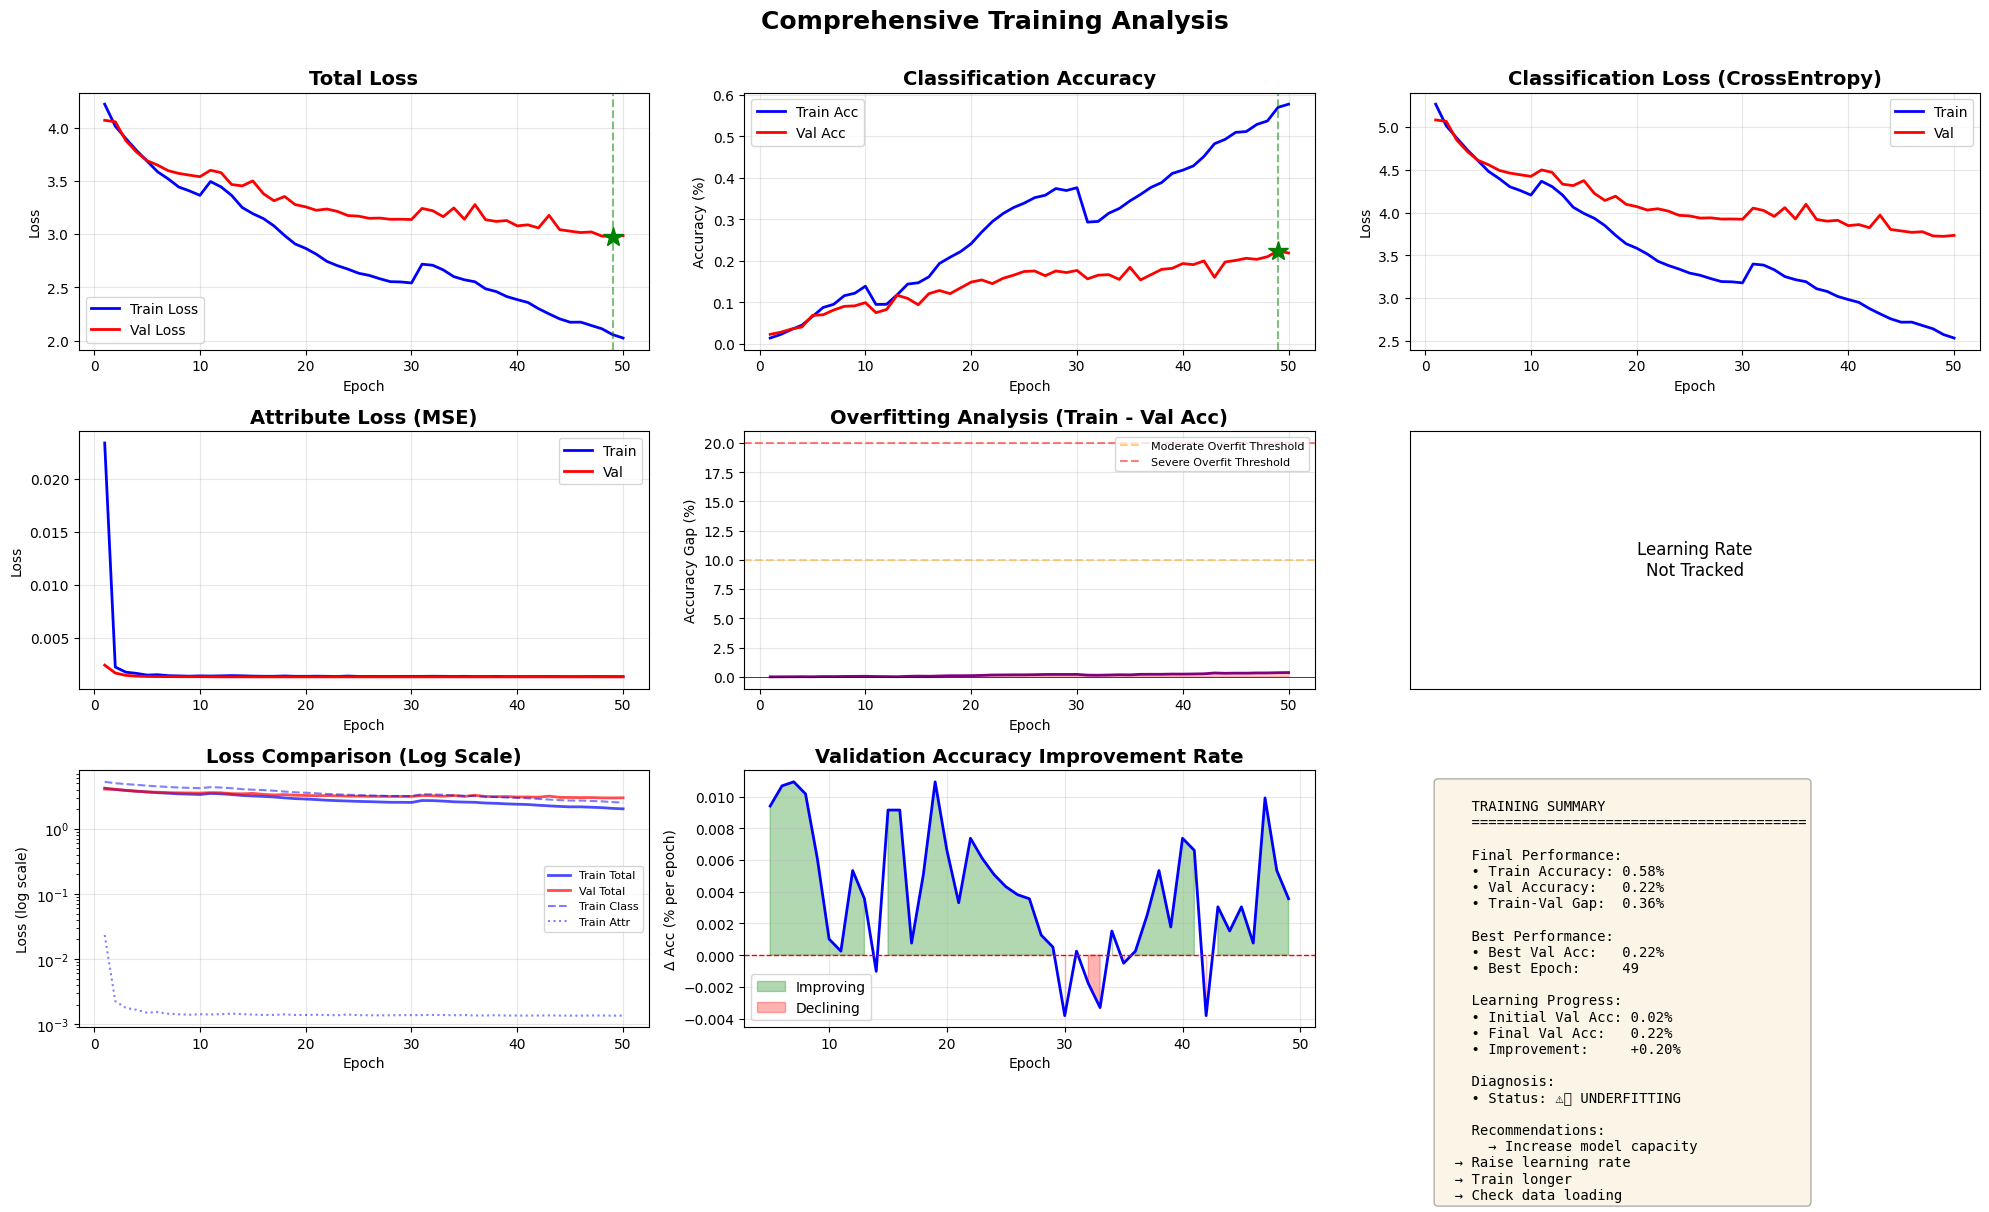

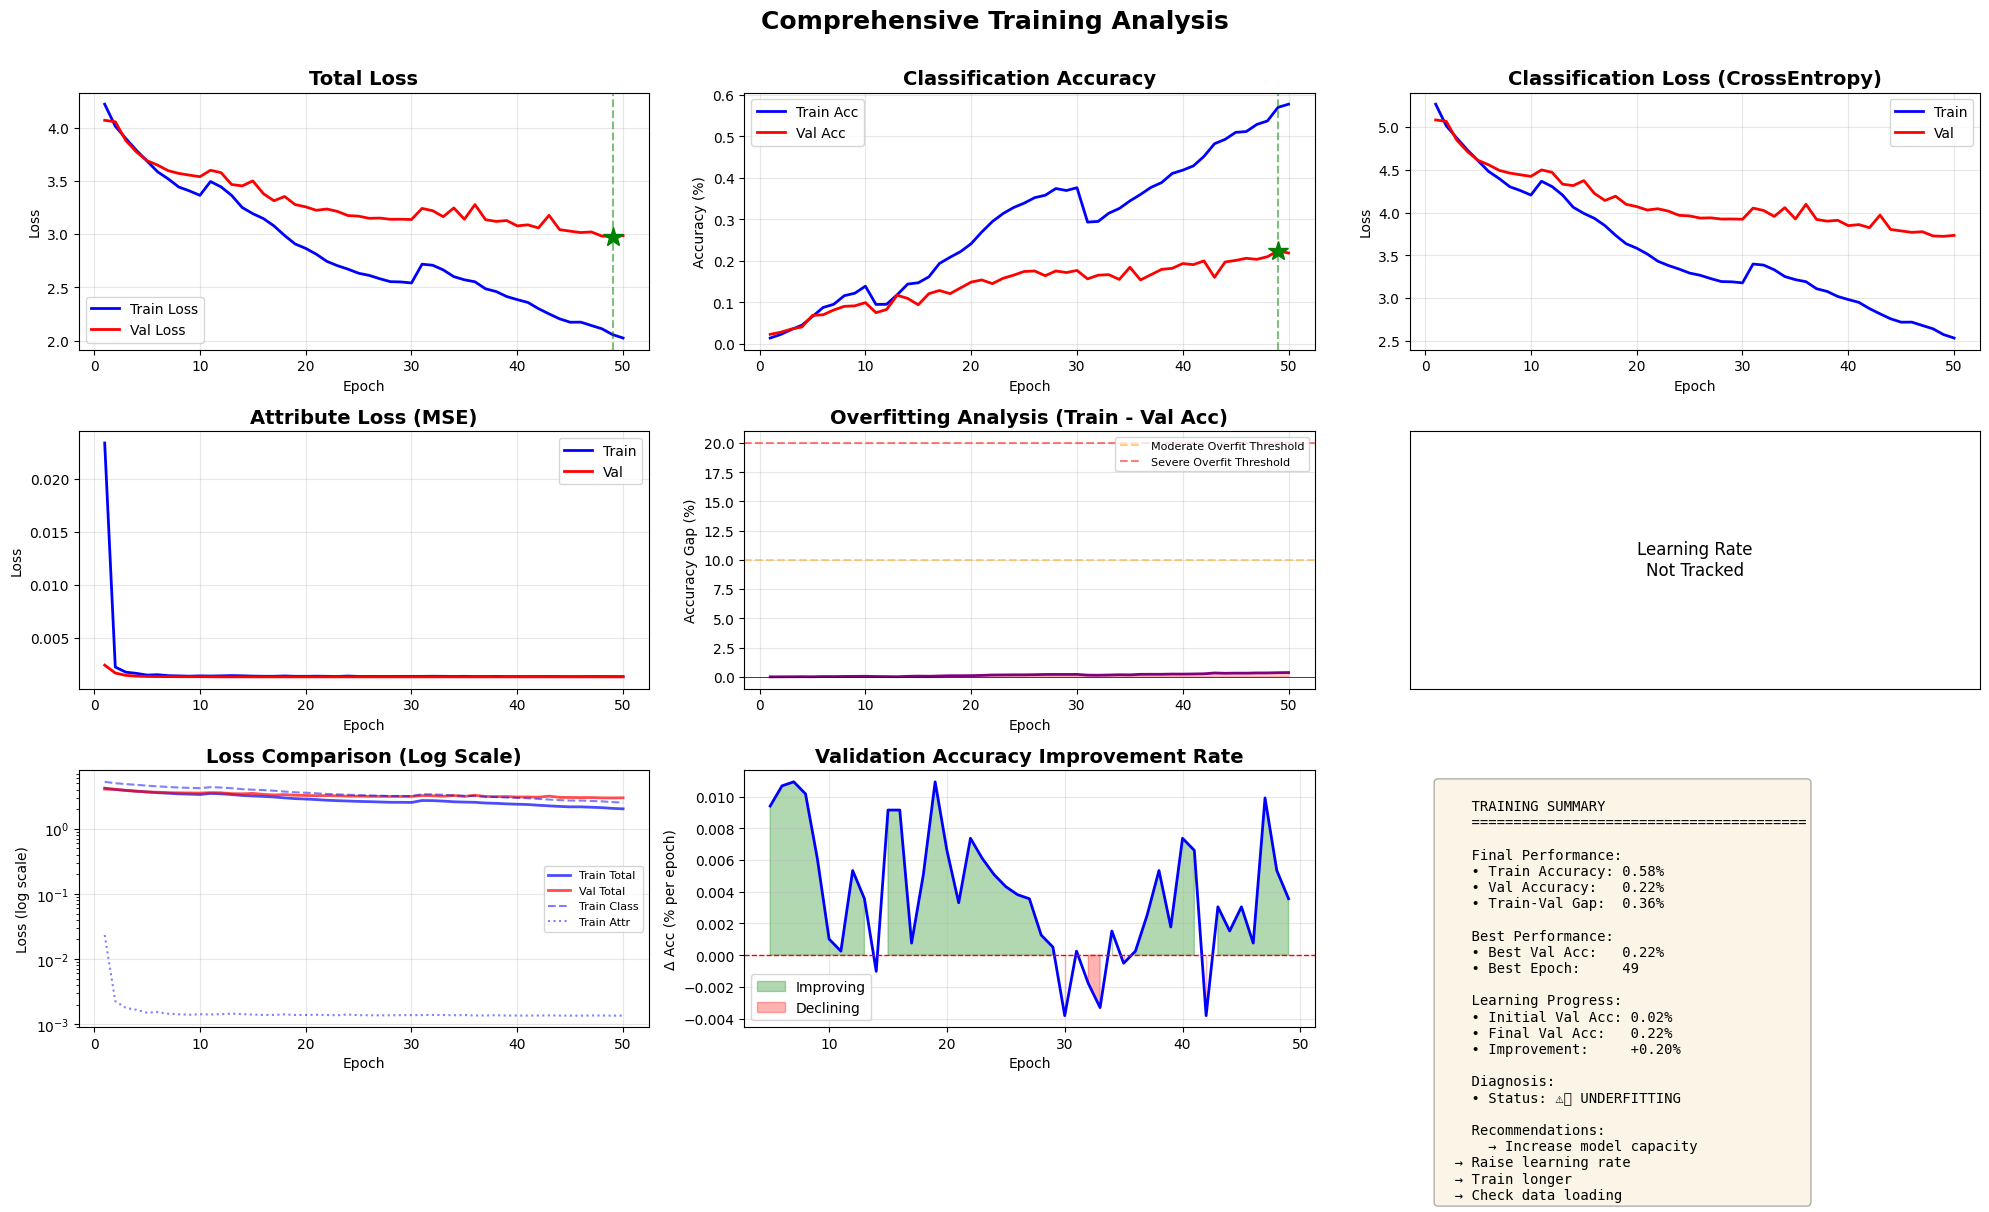

In [31]:
import matplotlib.pyplot as plt
def plot_comprehensive_training_history(history, save_path='training_analysis.png'):
    """
    Comprehensive training visualization with diagnostics

    Args:
        history: dict with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc',
                'train_class_loss', 'val_class_loss', 'train_attr_loss', 'val_attr_loss'
        save_path: where to save the plot
    """

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))

    epochs = range(1, len(history['train_loss']) + 1)

    # ========================================================================
    # 1. TOTAL LOSS
    # ========================================================================
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Total Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add best epoch marker
    best_epoch = np.argmin(history['val_loss']) + 1
    best_val_loss = min(history['val_loss'])
    ax1.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label=f'Best: Epoch {best_epoch}')
    ax1.plot(best_epoch, best_val_loss, 'g*', markersize=15)

    # ========================================================================
    # 2. ACCURACY
    # ========================================================================
    ax2 = plt.subplot(3, 3, 2)
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax2.set_title('Classification Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Add best epoch marker
    best_epoch_acc = np.argmax(history['val_acc']) + 1
    best_val_acc = max(history['val_acc'])
    ax2.axvline(x=best_epoch_acc, color='g', linestyle='--', alpha=0.5, label=f'Best: Epoch {best_epoch_acc}')
    ax2.plot(best_epoch_acc, best_val_acc, 'g*', markersize=15)

    # ========================================================================
    # 3. CLASSIFICATION LOSS
    # ========================================================================
    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(epochs, history['train_class_loss'], 'b-', label='Train', linewidth=2)
    ax3.plot(epochs, history['val_class_loss'], 'r-', label='Val', linewidth=2)
    ax3.set_title('Classification Loss (CrossEntropy)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # ========================================================================
    # 4. ATTRIBUTE LOSS
    # ========================================================================
    ax4 = plt.subplot(3, 3, 4)
    ax4.plot(epochs, history['train_attr_loss'], 'b-', label='Train', linewidth=2)
    ax4.plot(epochs, history['val_attr_loss'], 'r-', label='Val', linewidth=2)
    ax4.set_title('Attribute Loss (MSE)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # ========================================================================
    # 5. OVERFITTING ANALYSIS (Train-Val Gap)
    # ========================================================================
    ax5 = plt.subplot(3, 3, 5)
    acc_gap = [train - val for train, val in zip(history['train_acc'], history['val_acc'])]
    ax5.plot(epochs, acc_gap, 'purple', linewidth=2)
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax5.axhline(y=10, color='orange', linestyle='--', alpha=0.5, label='Moderate Overfit Threshold')
    ax5.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='Severe Overfit Threshold')
    ax5.set_title('Overfitting Analysis (Train - Val Acc)', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Accuracy Gap (%)')
    ax5.legend(fontsize=8)
    ax5.grid(True, alpha=0.3)
    ax5.fill_between(epochs, 0, acc_gap, where=[g > 0 for g in acc_gap],
                     color='red', alpha=0.2, label='Overfitting')

    # ========================================================================
    # 6. LEARNING RATE (if available)
    # ========================================================================
    ax6 = plt.subplot(3, 3, 6)
    if 'lr' in history:
        ax6.plot(epochs, history['lr'], 'g-', linewidth=2)
        ax6.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Epoch')
        ax6.set_ylabel('Learning Rate')
        ax6.set_yscale('log')
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'Learning Rate\nNot Tracked',
                ha='center', va='center', fontsize=12, transform=ax6.transAxes)
        ax6.set_xticks([])
        ax6.set_yticks([])

    # ========================================================================
    # 7. LOSS COMPARISON (Log Scale)
    # ========================================================================
    ax7 = plt.subplot(3, 3, 7)
    ax7.plot(epochs, history['train_loss'], 'b-', label='Train Total', linewidth=2, alpha=0.7)
    ax7.plot(epochs, history['val_loss'], 'r-', label='Val Total', linewidth=2, alpha=0.7)
    ax7.plot(epochs, history['train_class_loss'], 'b--', label='Train Class', linewidth=1.5, alpha=0.5)
    ax7.plot(epochs, history['train_attr_loss'], 'b:', label='Train Attr', linewidth=1.5, alpha=0.5)
    ax7.set_title('Loss Comparison (Log Scale)', fontsize=14, fontweight='bold')
    ax7.set_xlabel('Epoch')
    ax7.set_ylabel('Loss (log scale)')
    ax7.set_yscale('log')
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3)

    # ========================================================================
    # 8. ACCURACY IMPROVEMENT RATE
    # ========================================================================
    ax8 = plt.subplot(3, 3, 8)

    # Calculate moving average improvement (smoothed)
    window = 5
    val_acc_smooth = np.convolve(history['val_acc'], np.ones(window)/window, mode='valid')
    improvement = np.diff(val_acc_smooth)

    ax8.plot(range(window, len(history['val_acc'])), improvement, 'b-', linewidth=2)
    ax8.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax8.set_title('Validation Accuracy Improvement Rate', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Epoch')
    ax8.set_ylabel('Δ Acc (% per epoch)')
    ax8.grid(True, alpha=0.3)
    ax8.fill_between(range(window, len(history['val_acc'])), 0, improvement,
                     where=[i > 0 for i in improvement], color='green', alpha=0.3, label='Improving')
    ax8.fill_between(range(window, len(history['val_acc'])), 0, improvement,
                     where=[i < 0 for i in improvement], color='red', alpha=0.3, label='Declining')
    ax8.legend()

    # ========================================================================
    # 9. SUMMARY STATISTICS (Text)
    # ========================================================================
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    # Calculate statistics
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    best_val_acc = max(history['val_acc'])
    best_epoch = np.argmax(history['val_acc']) + 1
    train_val_gap = final_train_acc - final_val_acc

    initial_val_acc = history['val_acc'][0]
    total_improvement = final_val_acc - initial_val_acc

    # Determine status
    if train_val_gap > 20:
        status = "⚠️ SEVERE OVERFITTING"
        color = 'red'
    elif train_val_gap > 10:
        status = "⚠️ MODERATE OVERFITTING"
        color = 'orange'
    elif final_train_acc < 25:
        status = "⚠️ UNDERFITTING"
        color = 'orange'
    else:
        status = "✅ HEALTHY TRAINING"
        color = 'green'

    summary_text = f"""
    TRAINING SUMMARY
    {'='*40}

    Final Performance:
    • Train Accuracy: {final_train_acc:.2f}%
    • Val Accuracy:   {final_val_acc:.2f}%
    • Train-Val Gap:  {train_val_gap:.2f}%

    Best Performance:
    • Best Val Acc:   {best_val_acc:.2f}%
    • Best Epoch:     {best_epoch}

    Learning Progress:
    • Initial Val Acc: {initial_val_acc:.2f}%
    • Final Val Acc:   {final_val_acc:.2f}%
    • Improvement:     +{total_improvement:.2f}%

    Diagnosis:
    • Status: {status}

    Recommendations:
    """

    if train_val_gap > 20:
        recommendations = """  → Add more regularization
  → Use early stopping
  → Increase dropout
  → More data augmentation"""
    elif train_val_gap > 10:
        recommendations = """  → Consider early stopping
  → Moderate regularization"""
    elif final_train_acc < 25:
        recommendations = """  → Increase model capacity
  → Raise learning rate
  → Train longer
  → Check data loading"""
    else:
        recommendations = """  → Continue training
  → Fine-tune hyperparameters
  → Try ensemble methods"""

    summary_text += recommendations

    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    fig.suptitle('Comprehensive Training Analysis',
                fontsize=18, fontweight='bold', y=0.995)

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved comprehensive plot to {save_path}")
    plt.show()

    return fig


plot_comprehensive_training_history(history, save_path='training_analysis.png')